In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')

tickers = ['AAPL', 'MSFT', 'TSLA', 'JPM', 'XLE']

# force yfinance to give us the full OHLCV data WITHOUT auto adjusting
raw = yf.download(
    tickers,
    start='2022-01-01',
    auto_adjust=False,   # <— important
    progress=False
)

# extract just the adjusted close prices
prices = raw['Adj Close']

print("Columns:", list(prices.columns))
print("Shape of price data (rows x cols):", prices.shape)
prices.head()



Columns: ['AAPL', 'JPM', 'MSFT', 'TSLA', 'XLE']
Shape of price data (rows x cols): (957, 5)


Ticker,AAPL,JPM,MSFT,TSLA,XLE
Date,,,,,
2022-01-03,178.443146,145.583237,324.504608,399.926666,50.003014
2022-01-04,176.178406,151.102249,318.940338,383.196655,51.733284
2022-01-05,171.492081,148.339798,306.696838,362.706665,51.724552
2022-01-06,168.629272,149.915771,304.273346,354.899994,52.878052
2022-01-07,168.795944,151.401169,304.428497,342.320007,53.603371


In [4]:
# --- Step 1: compute daily returns ---
# pct_change() gives (P_t - P_{t-1}) / P_{t-1}
returns_daily = prices.pct_change().dropna()

# --- Step 2: compute annualized return for each asset ---
# logic:
# mean daily return * 252 trading days
annual_return = returns_daily.mean() * 252

# --- Step 3: compute annualized volatility for each asset ---
# logic:
# std of daily returns * sqrt(252)
annual_volatility = returns_daily.std() * np.sqrt(252)

# --- Step 4: combine into one summary DataFrame ---
summary_table = pd.DataFrame({
    'Annualized Return': annual_return,
    'Annualized Volatility': annual_volatility
})

# make it look nicer: convert to % for readability
summary_table['Annualized Return %'] = summary_table['Annualized Return'] * 100
summary_table['Annualized Volatility %'] = summary_table['Annualized Volatility'] * 100

# optional: round for clean display
summary_table = summary_table[['Annualized Return %', 'Annualized Volatility %']].round(2)

summary_table


,Annualized Return %,Annualized Volatility %
Ticker,,
AAPL,14.40,29.05
JPM,22.24,25.07
MSFT,16.26,27.04
TSLA,21.56,62.51
XLE,18.39,26.25


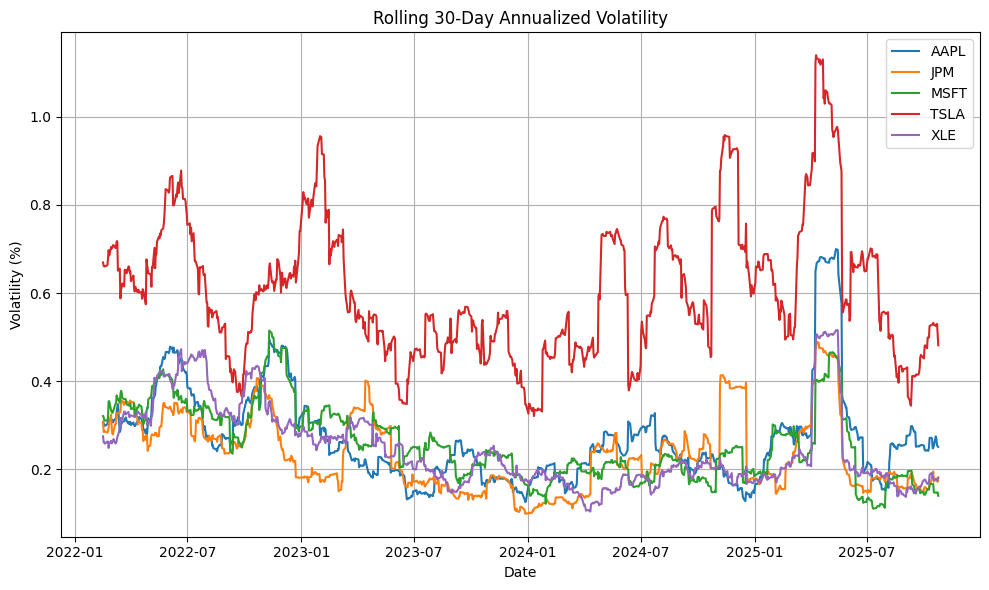

In [5]:
# --- Step 5: Rolling 30-Day Volatility ---
window = 30  # 30 trading days ≈ 1.5 months
rolling_vol = returns_daily.rolling(window).std() * np.sqrt(252)

plt.figure(figsize=(10,6))
for ticker in rolling_vol.columns:
    plt.plot(rolling_vol.index, rolling_vol[ticker], label=ticker)

plt.title('Rolling 30-Day Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


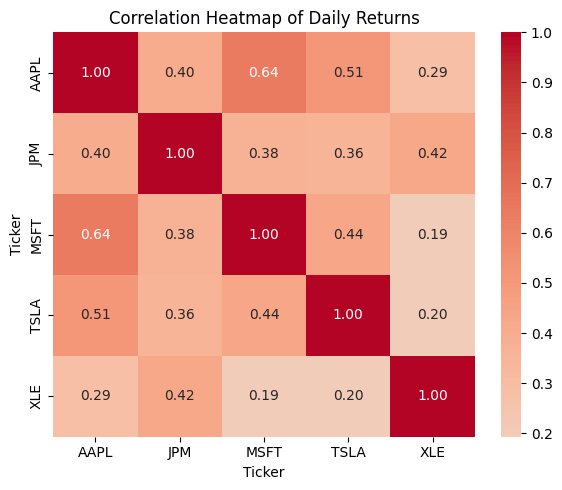

In [6]:
# --- Step 6: Correlation Matrix ---
corr_matrix = returns_daily.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap of Daily Returns')
plt.tight_layout()
plt.show()



# 📊 Interpretation & Insights

## 1. Rolling Volatility Analysis
The 30-day rolling annualized volatility shows how market risk evolved over time.  
- **TSLA** shows extreme volatility spikes (above 1.0), confirming it’s the most high-risk and unstable asset in the basket.  
- **AAPL** and **MSFT** remain moderate, hovering between 0.3–0.5, typical for large-cap tech stocks.  
- **JPM** and **XLE** show much lower and more stable volatility patterns, making them defensive and less sensitive to market swings.  

**Takeaway:** Tech stocks carry higher, more variable risk, while finance and energy sectors offer more predictable performance.

---

## 2. Correlation Heatmap Insights
The correlation heatmap shows how closely the assets move together.  
- **AAPL–MSFT (0.64)** → high correlation, meaning less diversification within tech.  
- **JPM (0.38–0.42)** and **XLE (0.19–0.42)** have weak correlations with tech stocks, improving diversification in a mixed portfolio.  
- **TSLA (0.36–0.51)** sits in the middle — partially moves with the market but introduces unique volatility.  

**Takeaway:** Combining assets from different sectors reduces overall portfolio risk.

---

## 3. Quantitative Summary

| Asset | Annualized Return (%) | Annualized Volatility (%) | Key Insight |
|:------|:----------------------:|:--------------------------:|:-------------|
| **AAPL** | 14.40 | 29.05 | Steady large-cap growth |
| **MSFT** | 16.26 | 27.04 | Strong performer, moderate risk |
| **TSLA** | 21.56 | 62.51 | High-risk, high-reward growth stock |
| **JPM** | 22.24 | 25.07 | Strong returns with lower volatility |
| **XLE** | 18.39 | 26.25 | Consistent and defensive |

**Key Learning:**  
Diversification across sectors (Tech, Finance, Energy) provides a balanced portfolio — high-return potential with controlled volatility.

---

## 4. Conclusion
This analysis quantifies **risk vs return** relationships across different sectors using real market data (2022–2025).  
It demonstrates how volatility and correlation drive portfolio construction decisions — a core principle in quantitative finance.

> “Risk is not inherently bad; unmanaged risk is.”


In [7]:
# --- Save plots as PNG files for README ---
plt.figure(figsize=(10,6))
for ticker in rolling_vol.columns:
    plt.plot(rolling_vol.index, rolling_vol[ticker], label=ticker)
plt.title('Rolling 30-Day Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../data/rolling_volatility.png', dpi=300)
plt.close()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap of Daily Returns')
plt.tight_layout()
plt.savefig('../data/correlation_heatmap.png', dpi=300)
plt.close()
